# Camera Tutorial

We will step through the simple functions that `face_rec` provides to allow you to use your camera via Python. Please be sure that you have installed OpenCV with the Python bindings (see repo README).

## Configuring Your Camera
Your camera configuration is comprised of:
  - your camera port (default=0)
  - the exposure time (default=0.1)
 
On devices with two cameras, you may need to set the port to 1 in order to access the keyboard-facing camera. This is the case on the Surface Pro, for instance. The exposure is the amount of time, in seconds, to wait before taking the picture. Increase the exposure time if your photo is too dark.

Let's test a configuration:

Testing port: 0, exposure: 1(sec)


<IPython.core.display.Javascript object>


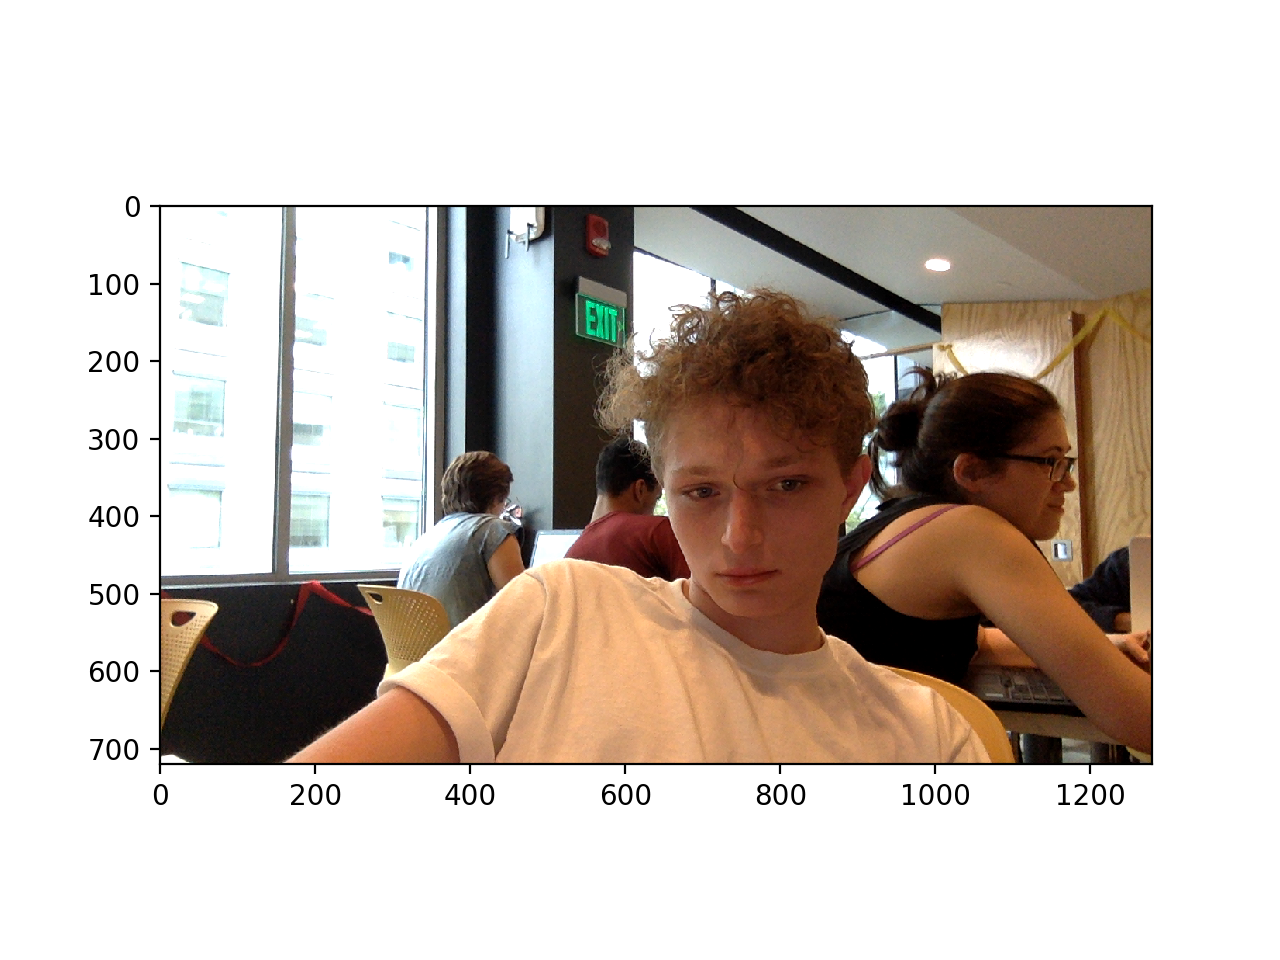

In [1]:
%matplotlib notebook
from camera import test_camera

fig, ax, img = test_camera(port=0, exposure=1)

Looks like this is a good configuration! If I had left the port and exposure blank, it would have used my current configured value - or the default values if there is no config file.

Saving the configuration:

In [2]:
from camera import save_camera_config
save_camera_config(port=0, exposure=0.2)

Configuration saved: 
	port: 0, exposure 0.2 (sec)


The config file is saved to: face_rec/camera/config.ini:

```
[camera device]
port = 1
exposure = 0.2
```

## Taking a Picture
Taking a picture returns the numpy array of RGB values of the photo. This can be displayed by using matplotlib's `imshow`. `take_picture` will use your saved camera configuration (or the default config).

<IPython.core.display.Javascript object>


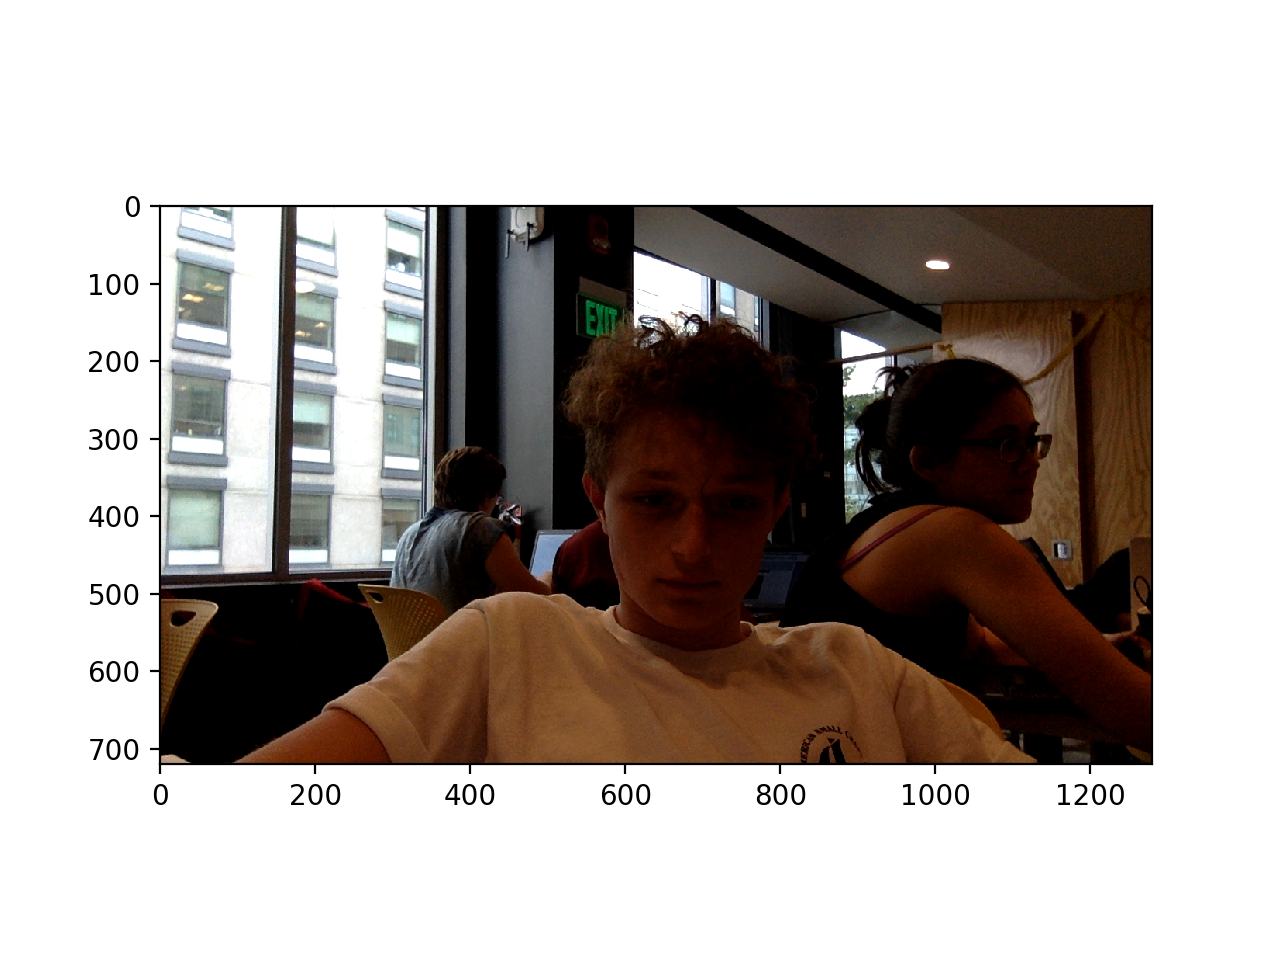

In [3]:
%matplotlib notebook
from camera import take_picture
import matplotlib.pyplot as plt
img_array = take_picture()

fig,ax = plt.subplots()
ax.imshow(img_array)

## Accessing the Camera
If you want to access the camera in a more generic way, a context manager is supplied so that control over the camera is always relinquished by your code. You can manually set the port and exposure time, bypassing the config/default, if you'd like. Read the [docs on `cv2.VideoCapture`](http://docs.opencv.org/2.4/modules/highgui/doc/reading_and_writing_images_and_video.html#videocapture-videocapture) for details into what can be done with the camera.

In [4]:
from camera import use_camera

# This will wait 0.5 seconds and then yield the active
# port-1 camera. Leaving the context releases the camera.
# You can read frames to take images or videos.
with use_camera(port=0, exposure=.5) as camera:
    # do stuff with camera
    # leaving this context releases camera
    pass



In [45]:
import skimage.io as io
import matplotlib.pyplot as plt
# read a picture in as a numpy-array
def getDetectors(img):
    img_array = io.imread("/Users/reneegloger/Documents/Github/Week2/Camera/Pics/Nick2.jpg")
    pic = img_array

    import dlib_models
    from dlib_models import load_dlib_models

    # this loads the dlib models into memory. You should only import the models *after* loading them.
    # This does lazy-loading: it doesn't do anything if the models are already loaded.
    load_dlib_models()

    from dlib_models import models  # must be called after loading the models

    face_detect = models["face detect"]

    # Number of times to upscale image before detecting faces.
    # When would you want to increase this number?
    upscale = 1 

    detections = face_detect(img_array, upscale)  # returns sequence of face-detections
    detections = list(detections)

    det = detections[0] # first detected face in image

    # bounding box dimensions for detection
    l, r, t, b = det.left(), det.right(), det.top(), det.bottom()

    shape_predictor = models["shape predict"]

<IPython.core.display.Javascript object>


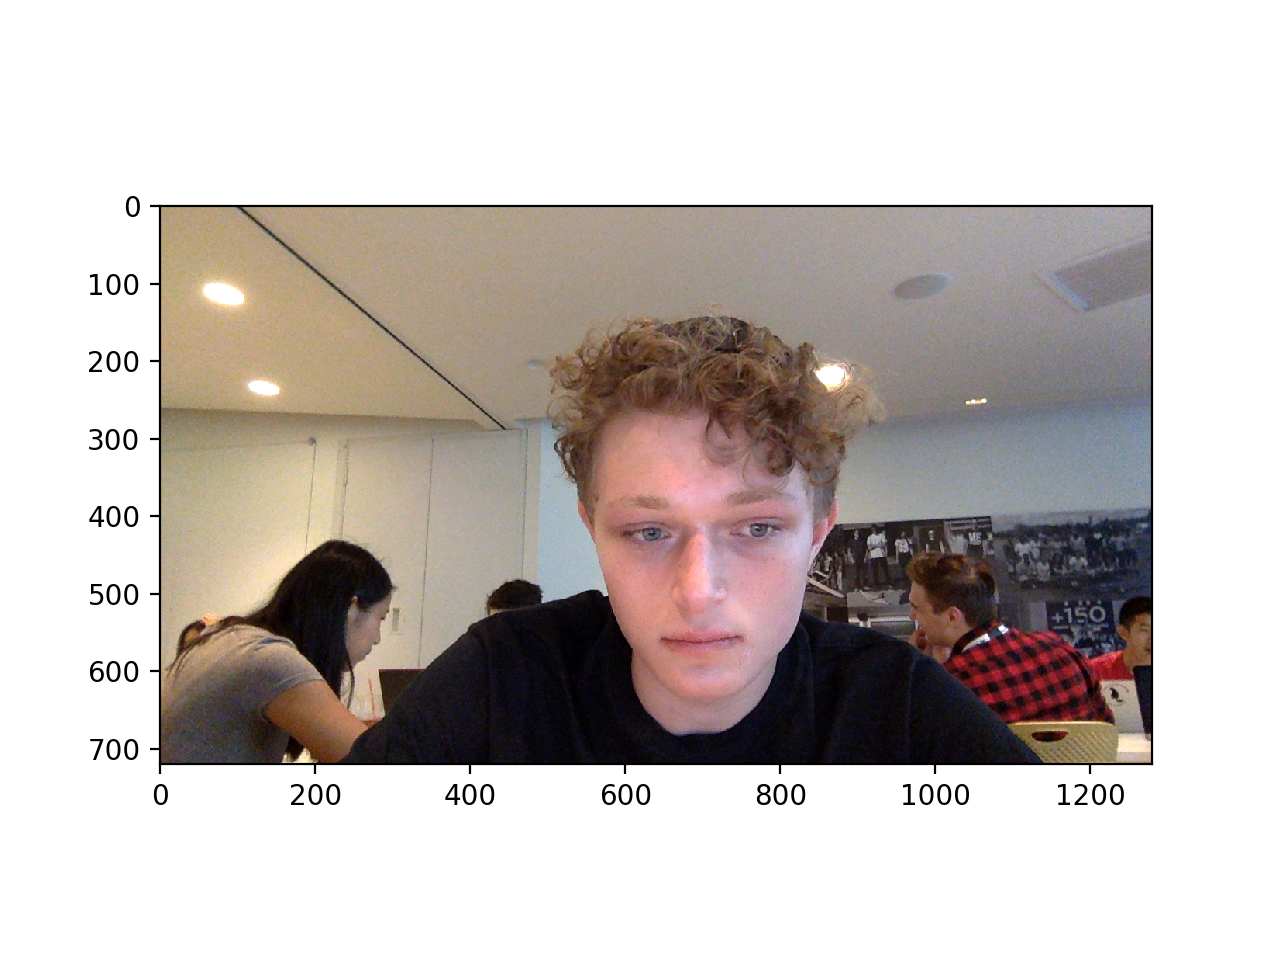

In [46]:
img_array = take_picture()

fig,ax = plt.subplots()
ax.imshow(img_array)

In [47]:
getDetectors(img_array)

In [34]:
import numpy as np
face_rec_model = models["face rec"]


# check that shape is (128,)
descriptor = np.array(face_rec_model.compute_face_descriptor(img_array, shape))

<IPython.core.display.Javascript object>


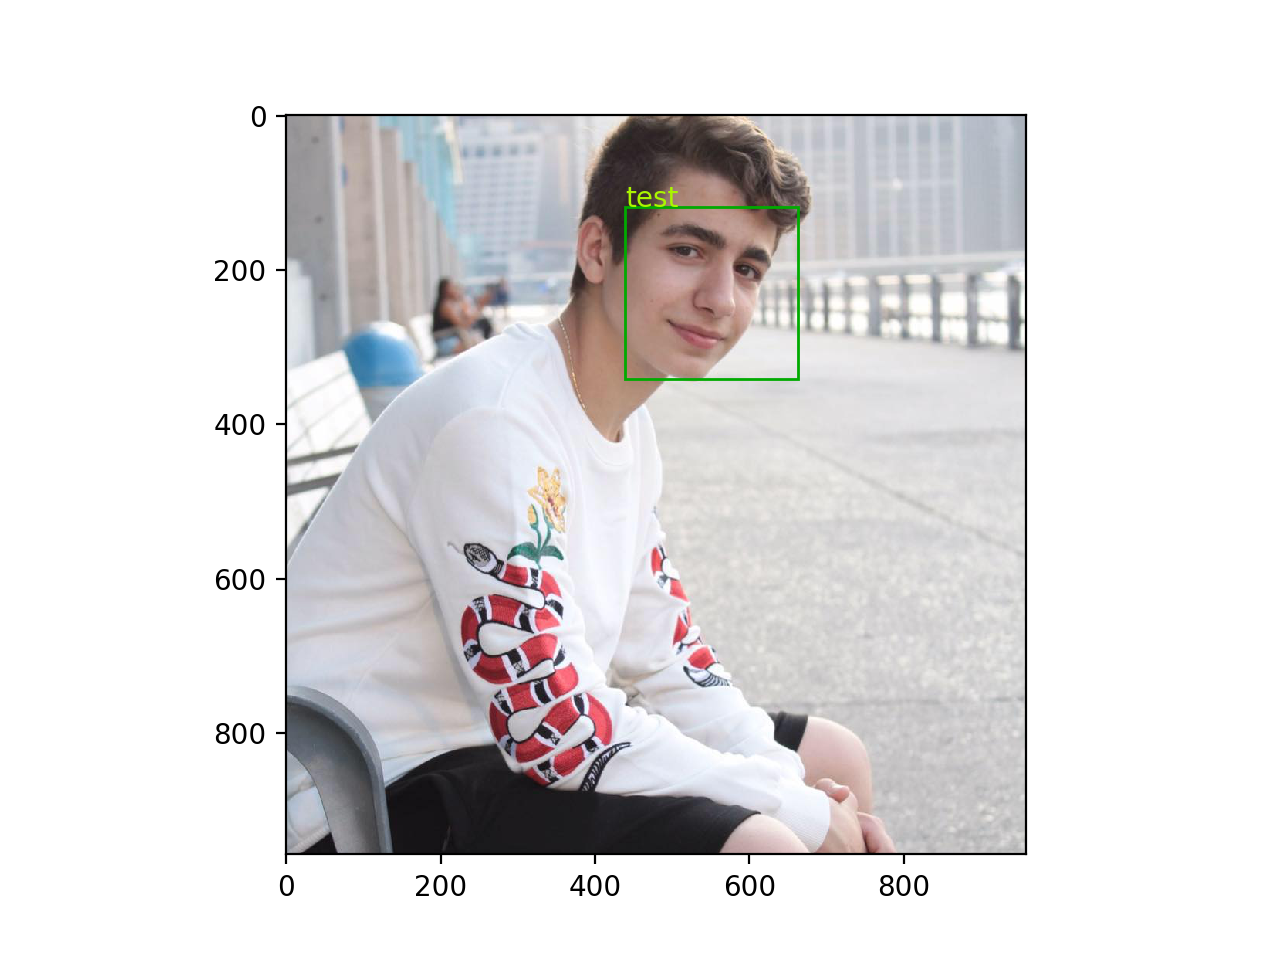

In [35]:
import matplotlib.patches as patches
#from face_rec import show_face_with_recognitions
fig,ax = plt.subplots()
ax.imshow(pic)
#ax.patch((faceRect.left(),faceRect.top()),faceRect.width(),faceRect.height())
#rectParam = ((faceRect.top(),faceRect.left()),faceRect.width(),faceRect.height())

descriptorsOfDetections = []

for det in detections:
    
    l, r, t, b = det.left(), det.right(), det.top(), det.bottom()
    ax.add_patch(patches.Rectangle((l,t),det.width(),det.height(),fill=False,edgecolor="#00aa00"))
    
    shape = shape_predictor(img_array, det)
    descriptorsOfDetections.append(shape)
    
    
    
    ax.text(l,t,"test",color="#aaf500")
#fig.savefig("Cface5.jpeg")

In [27]:
#desctriptorsDict["Nick Rago"] = descriptorsOfDetections[0]

In [37]:
desctriptorsDict = {}

def addToDataBase(Name,Descriptor):
    #desctriptorsDict[name] = (numofinstances,avgVector)
    if Name in desctriptorsDict:
        #figure Average
        NumInstances = desctriptorsDict[Name][0]+1
        NewAvg = desctriptorsDict[Name][1] + Descriptor/NumInstances
        desctriptorsDict[Name] = (NumInstances, NewAvg)
    else:
        desctriptorsDict[Name] = (1,Descriptor)

In [38]:
addToDataBase("Nick Rago", descriptorsOfDetections[0])

In [25]:
np.sqrt(np.sum((desc[0] - desc[1])**2))

NameError: name 'desc' is not defined

In [41]:
descriptorsOfDetections[0]

In [39]:
desctriptorsDict["Nick Rago"][1]

In [42]:
desctriptorsDict["Nick Rago"]

(1, <dlib.full_object_detection at 0x117d42630>)

In [43]:
def find_match(d, descriptor, tolerance=0):
    """
    :param:
        d:dict
            keys:str
                names of people
            values:np.array
                vector descriptor

        descriptor:np.array, shape = (128,)
            vector description of person's face
        tolerance:

    """
    best_match_name = "N/A"
    best_match_distance = 1e+300

    for name, vector in d.items():
        distance = np.sqrt(np.sum((descriptor - vector)**2)) #L2 distance
        if distance < best_match_distance:
            best_match_distance = distance
            best_match_name = name

    if best_match_distance < tolerance:
        return best_match_name
    else:
        return "Person not recognized."